In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 1: Load Data
print("📊 Step 1: Loading Data...")
df = pd.read_csv("data.csv", sep='\t')
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst few rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nData Info:")
df.info()

📊 Step 1: Loading Data...
✅ Data loaded: 19719 rows, 57 columns

First few rows:
   race  age  engnat  gender  hand  source country  E1  E2  E3  ...  O1  O2  \
0     3   53       1       1     1       1      US   4   2   5  ...   4   1   
1    13   46       1       2     1       1      US   2   2   3  ...   3   3   
2     1   14       2       2     1       1      PK   5   1   1  ...   4   5   
3     3   19       2       2     1       1      RO   2   5   2  ...   4   3   
4    11   25       2       2     1       2      US   3   1   3  ...   3   1   

   O3  O4  O5  O6  O7  O8  O9  O10  
0   3   1   5   1   4   2   5    5  
1   3   3   2   3   3   1   3    2  
2   5   1   5   1   5   5   5    5  
3   5   2   4   2   5   2   5    5  
4   1   1   3   1   3   1   5    3  

[5 rows x 57 columns]

Columns: ['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A

In [4]:
# Step 2: Handle Missing Values
print("\n🧹 Step 2: Cleaning Data...")
missing_summary = df.isnull().sum()
print(f"Total missing values: {missing_summary.sum()}")
if missing_summary.sum() > 0:
    print("\nMissing values per column:")
    print(missing_summary[missing_summary > 0])

# Drop rows with missing country
df = df.dropna(subset=['country'])
print(f"\nAfter dropping missing values: {df.shape}")


🧹 Step 2: Cleaning Data...
Total missing values: 9

Missing values per column:
country    9
dtype: int64

After dropping missing values: (19710, 57)


In [5]:
# Step 3: Clean Age Column
print("\n🔢 Step 3: Cleaning Age and Encoding Categorical Variables...")
if 'age' in df.columns:
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    invalid_count_before = df['age'].isnull().sum()
    # Cap age at reasonable range (13 to 120 years)
    df.loc[df['age'] < 13, 'age'] = np.nan
    df.loc[df['age'] > 120, 'age'] = np.nan
    invalid_count_after = df['age'].isnull().sum()
    if invalid_count_after > invalid_count_before:
        print(f"Cleaned {invalid_count_after - invalid_count_before} invalid age entries")
    age_median = df['age'].median()
    df['age'] = df['age'].fillna(age_median)

# Encode Categorical Variables
categorical_cols = ['race', 'engnat', 'gender', 'hand', 'source', 'country']
label_encoders = {}

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

print("✅ Categorical Encoding Done")
if 'age' in df.columns:
    print(f"Age range (after cleaning): {df['age'].min():.0f} to {df['age'].max():.0f}")
    print(f"Age mean: {df['age'].mean():.2f}, median: {df['age'].median():.2f}")


🔢 Step 3: Cleaning Age and Encoding Categorical Variables...
Cleaned 82 invalid age entries
✅ Categorical Encoding Done
Age range (after cleaning): 13 to 118
Age mean: 26.25, median: 22.00


In [6]:
# Step 4: Ensure all personality trait columns are numeric
print("\n📈 Step 4: Processing Trait Columns...")
trait_cols = []
for prefix in ['E', 'N', 'A', 'C', 'O']:
    for i in range(1, 11):
        col = f'{prefix}{i}'
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            trait_cols.append(col)

print(f"✅ Converted {len(trait_cols)} trait columns to numeric")


📈 Step 4: Processing Trait Columns...
✅ Converted 50 trait columns to numeric


In [7]:
# Step 5: Compute Personality Scores (Average of Each Trait)
print("\n🎯 Step 5: Computing Personality Scores...")
E_cols = [f'E{i}' for i in range(1, 11) if f'E{i}' in df.columns]
N_cols = [f'N{i}' for i in range(1, 11) if f'N{i}' in df.columns]
A_cols = [f'A{i}' for i in range(1, 11) if f'A{i}' in df.columns]
C_cols = [f'C{i}' for i in range(1, 11) if f'C{i}' in df.columns]
O_cols = [f'O{i}' for i in range(1, 11) if f'O{i}' in df.columns]

df['EXTRAVERSION'] = df[E_cols].mean(axis=1)
df['NEUROTICISM'] = df[N_cols].mean(axis=1)
df['AGREEABLENESS'] = df[A_cols].mean(axis=1)
df['CONSCIENTIOUSNESS'] = df[C_cols].mean(axis=1)
df['OPENNESS'] = df[O_cols].mean(axis=1)

print("✅ Personality Scores Computed")
print(f"Extraversion range: {df['EXTRAVERSION'].min():.2f} to {df['EXTRAVERSION'].max():.2f}")
print(f"Neuroticism range: {df['NEUROTICISM'].min():.2f} to {df['NEUROTICISM'].max():.2f}")
print(f"Agreeableness range: {df['AGREEABLENESS'].min():.2f} to {df['AGREEABLENESS'].max():.2f}")
print(f"Conscientiousness range: {df['CONSCIENTIOUSNESS'].min():.2f} to {df['CONSCIENTIOUSNESS'].max():.2f}")
print(f"Openness range: {df['OPENNESS'].min():.2f} to {df['OPENNESS'].max():.2f}")


🎯 Step 5: Computing Personality Scores...
✅ Personality Scores Computed
Extraversion range: 0.00 to 5.00
Neuroticism range: 0.00 to 5.00
Agreeableness range: 0.00 to 5.00
Conscientiousness range: 0.00 to 5.00
Openness range: 0.00 to 5.00


In [8]:
# Step 6: Create Personality Labels
print("\n🏷️  Step 6: Creating Personality Labels...")
def assign_personality(row):
    traits = ['EXTRAVERSION', 'NEUROTICISM', 'AGREEABLENESS', 'CONSCIENTIOUSNESS', 'OPENNESS']
    trait_values = {t: row[t] for t in traits}
    highest_trait = max(trait_values, key=trait_values.get)
    trait_names = {
        'EXTRAVERSION': 'Extraversion',
        'NEUROTICISM': 'Neuroticism',
        'AGREEABLENESS': 'Agreeableness',
        'CONSCIENTIOUSNESS': 'Conscientiousness',
        'OPENNESS': 'Openness'
    }
    return trait_names[highest_trait]

df['Personality'] = df.apply(assign_personality, axis=1)
print("✅ Personality Labels Assigned")
print("\nPersonality Distribution:")
print(df['Personality'].value_counts())


🏷️  Step 6: Creating Personality Labels...
✅ Personality Labels Assigned

Personality Distribution:
Personality
Neuroticism          5695
Openness             5484
Agreeableness        3287
Extraversion         2689
Conscientiousness    2555
Name: count, dtype: int64


In [10]:
# Step 7: Prepare Data for ML
print("\n🔧 Step 7: Preparing Features...")

feature_cols = E_cols + N_cols + A_cols + C_cols + O_cols + ['race', 'age', 'engnat', 'gender', 'hand', 'source']

# Encode country if needed, or drop it if too many categories
if 'country' in df.columns:
    if df['country'].nunique() > 50:  # If too many countries, drop it
        print("Dropping 'country' column due to high cardinality")
    else:
        feature_cols.append('country')

# Filter to only columns that exist
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].copy()
y = df['Personality'].copy()

# Handle any remaining missing values
X = X.fillna(X.mean())

print(f"✅ Prepared {len(feature_cols)} features")
print(f"Feature columns: {feature_cols}")


🔧 Step 7: Preparing Features...
Dropping 'country' column due to high cardinality
✅ Prepared 56 features
Feature columns: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'race', 'age', 'engnat', 'gender', 'hand', 'source']


In [11]:
# Step 8: Scale Features and Split Data
print("\n📏 Step 8: Scaling Features and Splitting Data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())


📏 Step 8: Scaling Features and Splitting Data...
✅ Train: (15768, 56), Test: (3942, 56)

Class distribution in training set:
Personality
Neuroticism          4556
Openness             4387
Agreeableness        2630
Extraversion         2151
Conscientiousness    2044
Name: count, dtype: int64


In [12]:
# Step 9: Train and Evaluate Multiple Models
print("\n🤖 Step 9: Training Models...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"\n  Training {name}...")
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "CV Mean": cv_mean,
        "CV Std": cv_std
    })
    
    trained_models[name] = model
    print(f"    Test Accuracy: {test_acc:.4f} | CV Score: {cv_mean:.4f} (±{cv_std:.4f})")

results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False)
print("\n" + "="*70)
print("📊 MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))


🤖 Step 9: Training Models...

  Training Logistic Regression...
    Test Accuracy: 1.0000 | CV Score: 0.9991 (±0.0004)

  Training Random Forest...
    Test Accuracy: 0.6773 | CV Score: 0.6698 (±0.0059)

  Training Gradient Boosting...
    Test Accuracy: 0.8990 | CV Score: 0.8930 (±0.0058)

  Training SVM...
    Test Accuracy: 0.9292 | CV Score: 0.9197 (±0.0037)

  Training KNN...
    Test Accuracy: 0.5906 | CV Score: 0.5856 (±0.0046)

  Training Naive Bayes...
    Test Accuracy: 0.6550 | CV Score: 0.6468 (±0.0088)

  Training Decision Tree...
    Test Accuracy: 0.5000 | CV Score: 0.5070 (±0.0063)

📊 MODEL COMPARISON
              Model  Train Accuracy  Test Accuracy  CV Mean   CV Std
Logistic Regression        0.999746       1.000000 0.999112 0.000370
                SVM        0.993595       0.929224 0.919711 0.003721
  Gradient Boosting        0.950152       0.899036 0.893012 0.005814
      Random Forest        1.000000       0.677321 0.669774 0.005907
        Naive Bayes        0.


📊 Step 10: Model Comparison Visualization


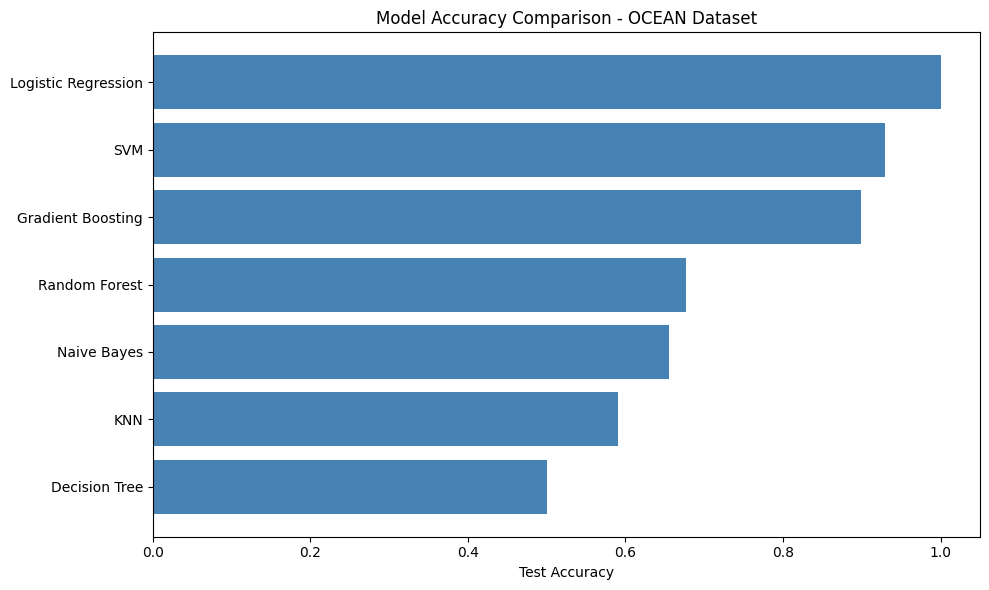


Best Model: SVM
Best Accuracy: 0.9292


In [15]:
# Step 10: Visualize Model Comparison
print("\n📊 Step 10: Model Comparison Visualization")
plt.figure(figsize=(10, 6))
results_df_sorted = results_df.sort_values('Test Accuracy', ascending=True)
plt.barh(results_df_sorted['Model'], results_df_sorted['Test Accuracy'], color='steelblue')
plt.xlabel('Test Accuracy')
plt.title('Model Accuracy Comparison - OCEAN Dataset')
plt.tight_layout()
plt.show()

print("\nBest Model:", results_df.iloc[1]['Model'])
print("Best Accuracy:", f"{results_df.iloc[1]['Test Accuracy']:.4f}")

In [16]:
# Step 11: Hyperparameter Tuning on 2nd Best Model
print("\n🎯 Step 11: Hyperparameter Tuning on 2nd Best Model...")
best_model_name = results_df.iloc[1]['Model']
best_base_model = trained_models[best_model_name]

print(f"Tuning {best_model_name}...")

if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
else:
    best_model = best_base_model
    print("No tuning applied for this model type")


🎯 Step 11: Hyperparameter Tuning on 2nd Best Model...
Tuning SVM...
No tuning applied for this model type



🏆 Step 12: Final Model Evaluation...

✅ Best Model: SVM
✅ Final Test Accuracy: 0.9292

📋 Classification Report:
                   precision    recall  f1-score   support

    Agreeableness       0.92      0.91      0.91       657
Conscientiousness       0.94      0.86      0.90       511
     Extraversion       0.94      0.90      0.92       538
      Neuroticism       0.93      0.97      0.95      1139
         Openness       0.92      0.95      0.93      1097

         accuracy                           0.93      3942
        macro avg       0.93      0.92      0.92      3942
     weighted avg       0.93      0.93      0.93      3942



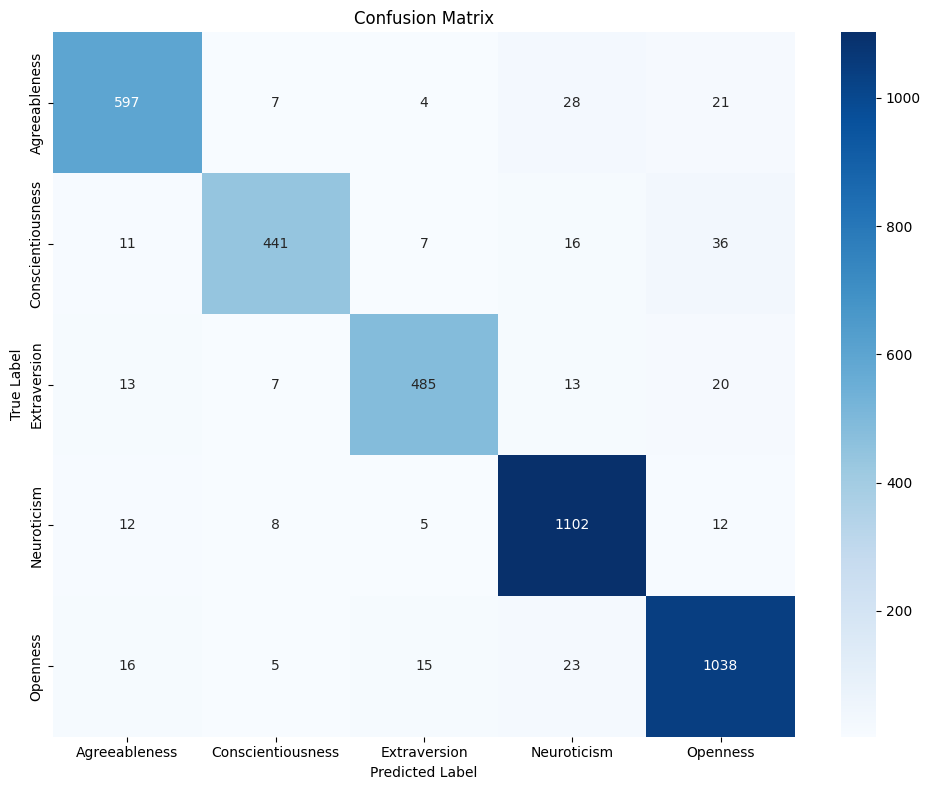

In [17]:
# Step 12: Final Model Evaluation
print("\n🏆 Step 12: Final Model Evaluation...")
final_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)

print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ Final Test Accuracy: {final_acc:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, final_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [18]:
# Step 13: Save Model and Preprocessors
print("\n💾 Step 13: Saving Model...")
model_data = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_cols': feature_cols,
    'E_cols': E_cols,
    'N_cols': N_cols,
    'A_cols': A_cols,
    'C_cols': C_cols,
    'O_cols': O_cols,
    'model_name': best_model_name,
    'accuracy': final_acc
}

with open('personality_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved to 'personality_model.pkl'")
print("\n🎉 Training Complete!")
print(f"📈 Best Model: {best_model_name} with {final_acc:.4f} accuracy")


💾 Step 13: Saving Model...
✅ Model saved to 'personality_model.pkl'

🎉 Training Complete!
📈 Best Model: SVM with 0.9292 accuracy
